# Wheat Futures Return Prediction: Feasibility Study

**Objective:** Test whether agricultural alternative data from CY-Bench (weather, soil moisture, vegetation indices) can improve the prediction of 20-day forward wheat futures returns beyond what price data alone can achieve.

**Setup:**
- **Target:** Binary classification — positive or negative 20-day forward returns on Milling Wheat N2 futures
- **Baseline model:** Uses only price-derived technical features
- **Enhanced model:** Adds CY-Bench agricultural features from France (largest EU wheat producer), aggregated across 91 regions and lagged by 20 days
- **Model:** Logistic Regression (simple, explainable, appropriate for a feasibility check)
- **Period:** 2003–2023

In [25]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
from datetime import timedelta

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, f1_score
)
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("All imports successful.")

All imports successful.


---
## 1. Load and Prepare Futures Price Data

In [26]:
# ============================================================
# CONFIGURATION - Update these paths to match your setup
# ============================================================
FUTURES_PATH = "Milling Wheat N2 Futures Historical Data.csv"
CYBENCH_DATA_DIR = "cy-bench"  # Path to your downloaded CY-Bench data

FORECAST_HORIZON = 5   # 5 trading days (1 week) forward return
AG_LAG_DAYS = 0        # No artificial lag: futures traders react to weather
                       # in real time. The rolling window features (30/60d)
                       # already provide the natural backward lookback

# ============================================================
# Load futures data
# ============================================================
futures_raw = pd.read_csv(FUTURES_PATH)
print(f"Raw futures data shape: {futures_raw.shape}")
futures_raw.head()

Raw futures data shape: (6938, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,02/12/2026,192.25,191.00,192.50,190.00,51.93K,0.92%
1,02/11/2026,190.50,189.75,191.50,189.75,47.70K,0.53%
2,02/10/2026,189.50,189.25,191.25,189.00,44.92K,0.00%
3,02/09/2026,189.50,189.00,190.50,188.50,46.47K,-0.26%
4,02/06/2026,190.00,193.25,193.75,189.75,65.48K,-1.81%


In [27]:
# Parse and clean futures data
futures = futures_raw.copy()
futures['Date'] = pd.to_datetime(futures['Date'], format='%m/%d/%Y')
futures = futures.sort_values('Date').reset_index(drop=True)

# Clean numeric columns
for col in ['Price', 'Open', 'High', 'Low']:
    futures[col] = pd.to_numeric(
        futures[col].astype(str).str.replace(',', ''), errors='coerce'
    )

# Clean volume (handle K, M suffixes)
def parse_volume(v):
    v = str(v).strip().replace(',', '')
    if v == '-' or v == 'nan' or v == '':
        return np.nan
    if v.upper().endswith('K'):
        return float(v[:-1]) * 1000
    if v.upper().endswith('M'):
        return float(v[:-1]) * 1_000_000
    return float(v)

futures['Volume'] = futures['Vol.'].apply(parse_volume)

# Clean change %
futures['Change_Pct'] = pd.to_numeric(
    futures['Change %'].astype(str).str.replace('%', ''), errors='coerce'
)

# Filter to 2003-2023
futures = futures[
    (futures['Date'] >= '2002-12-31') & (futures['Date'] <= '2023-12-31')
].copy()

futures = futures[['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change_Pct']]
futures = futures.dropna(subset=['Price']).reset_index(drop=True)

print(f"Futures data: {futures.shape[0]} trading days from {futures['Date'].min().date()} to {futures['Date'].max().date()}")
futures.head()

Futures data: 5379 trading days from 2002-12-31 to 2023-12-29


,Date,Price,Open,High,Low,Volume,Change_Pct
0,2002-12-31,112.00,112.25,112.25,112.00,0.0,-0.22
1,2003-01-02,112.00,112.00,112.00,112.00,NaN,0.00
2,2003-01-03,112.00,112.00,112.00,112.00,NaN,0.00
3,2003-01-06,111.75,112.00,112.00,111.75,90.0,-0.22
4,2003-01-07,111.25,111.50,111.50,111.25,100.0,-0.45


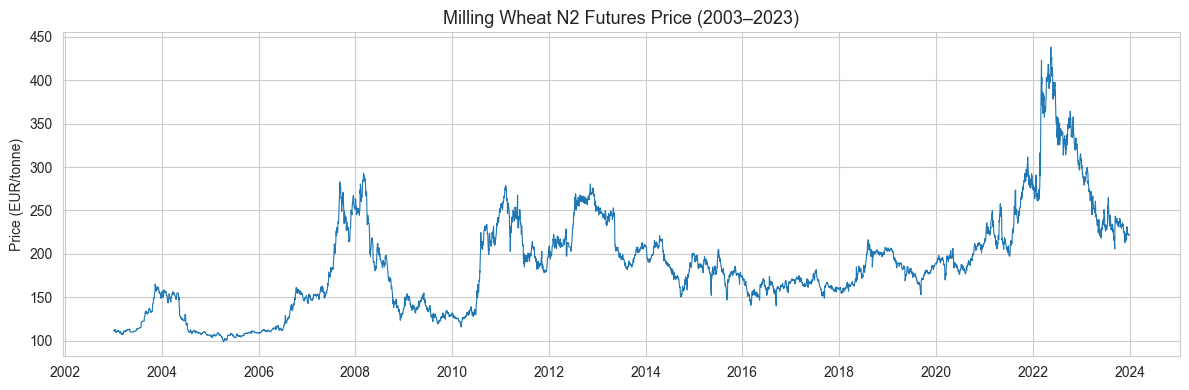

In [28]:
# Quick price plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(futures['Date'], futures['Price'], linewidth=0.8)
ax.set_title('Milling Wheat N2 Futures Price (2003–2023)', fontsize=13)
ax.set_ylabel('Price (EUR/tonne)')
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

---
## 2. Create Target Variable and Price-Only Features

In [29]:
# ============================================================
# Target: sign of 5-day (1 trading week) forward return
# ============================================================
futures['Fwd_Return'] = futures['Price'].shift(-FORECAST_HORIZON) / futures['Price'] - 1
futures['Target'] = (futures['Fwd_Return'] > 0).astype(int)

# ============================================================
# Price-only features (technical indicators)
# ============================================================
# Returns at various lookbacks
for lb in [1, 5, 10, 20, 60]:
    futures[f'ret_{lb}d'] = futures['Price'].pct_change(lb)

# Simple moving averages ratios
for w in [5, 10, 20, 50]:
    sma = futures['Price'].rolling(w).mean()
    futures[f'sma_ratio_{w}d'] = futures['Price'] / sma - 1

# Realised volatility
for w in [10, 20, 60]:
    futures[f'vol_{w}d'] = futures['Price'].pct_change().rolling(w).std()

# High-low range (normalised)
futures['hl_range'] = (futures['High'] - futures['Low']) / futures['Price']
futures['hl_range_20d_avg'] = futures['hl_range'].rolling(20).mean()

# Volume features
futures['vol_sma_ratio'] = futures['Volume'] / futures['Volume'].rolling(20).mean()

# RSI (14-day)
delta = futures['Price'].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = (-delta.clip(upper=0)).rolling(14).mean()
rs = gain / loss
futures['rsi_14'] = 100 - (100 / (1 + rs))

price_feature_cols = [
    col for col in futures.columns 
    if col not in ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 
                   'Change_Pct', 'Fwd_Return', 'Target']
]
print(f"Price-only features ({len(price_feature_cols)}): {price_feature_cols}")

Price-only features (16): ['ret_1d', 'ret_5d', 'ret_10d', 'ret_20d', 'ret_60d', 'sma_ratio_5d', 'sma_ratio_10d', 'sma_ratio_20d', 'sma_ratio_50d', 'vol_10d', 'vol_20d', 'vol_60d', 'hl_range', 'hl_range_20d_avg', 'vol_sma_ratio', 'rsi_14']


---
## 3. Load CY-Bench Agricultural Data for France

In [30]:
# ============================================================
# France is part of the EU dataset in CY-Bench.
# EU wheat data uses country code format; France regions have
# adm_id values starting with "FR".
#
# We load each CSV type for wheat in the EU folder and filter
# to French regions.
# ============================================================

# Try multiple possible directory structures
possible_paths = [
    os.path.join(CYBENCH_DATA_DIR,"EU"),
    os.path.join(CYBENCH_DATA_DIR,"FR"),
    os.path.join(CYBENCH_DATA_DIR),
]

wheat_eu_dir = None
for p in possible_paths:
    if os.path.isdir(p):
        wheat_eu_dir = p
        break

if wheat_eu_dir is None:
    raise FileNotFoundError(
        f"Could not find wheat EU/FR data. Searched: {possible_paths}\n"
        f"Please set CYBENCH_DATA_DIR to the root of your CY-Bench data folder."
    )

print(f"Using CY-Bench wheat directory: {wheat_eu_dir}")
print(f"Files found: {os.listdir(wheat_eu_dir)[:15]}...")

Using CY-Bench wheat directory: cy-bench\FR
Files found: ['crop_calendar_wheat_FR.csv', 'crop_mask_wheat_FR.csv', 'fpar_wheat_FR.csv', 'location_wheat_FR.csv', 'meteo_wheat_FR.csv', 'ndvi_wheat_FR.csv', 'soil_moisture_wheat_FR.csv', 'soil_wheat_FR.csv', 'yield_wheat_FR.csv']...


In [31]:
# ============================================================
# Load each data category
# ============================================================

def load_cybench_csv(directory, pattern):
    """Load a CY-Bench CSV file matching a glob pattern."""
    matches = glob.glob(os.path.join(directory, pattern))
    if not matches:
        print(f"  WARNING: No file matching '{pattern}' in {directory}")
        return None
    df = pd.read_csv(matches[0])
    print(f"  Loaded {os.path.basename(matches[0])}: {df.shape}")
    return df

print("Loading CY-Bench data for wheat (FR)...")
meteo_df = load_cybench_csv(wheat_eu_dir, "meteo_wheat_FR.csv")
soil_moisture_df = load_cybench_csv(wheat_eu_dir, "soil_moisture_wheat_FR.csv")
fpar_df = load_cybench_csv(wheat_eu_dir, "fpar_wheat_FR.csv")
ndvi_df = load_cybench_csv(wheat_eu_dir, "ndvi_wheat_FR.csv")
soil_df = load_cybench_csv(wheat_eu_dir, "soil_wheat_FR.csv")
yield_df = load_cybench_csv(wheat_eu_dir, "yield_wheat_FR.csv")
crop_cal_df = load_cybench_csv(wheat_eu_dir, "crop_calendar_wheat_FR.csv")
print(yield_df)

Loading CY-Bench data for wheat (FR)...
  Loaded meteo_wheat_FR.csv: (814800, 11)
  Loaded soil_moisture_wheat_FR.csv: (740886, 5)
  Loaded fpar_wheat_FR.csv: (80316, 4)
  Loaded ndvi_wheat_FR.csv: (97951, 4)
  Loaded soil_wheat_FR.csv: (97, 5)
  Loaded yield_wheat_FR.csv: (2571, 7)
  Loaded crop_calendar_wheat_FR.csv: (97, 4)
         crop_name country_code adm_id  harvest_year  yield  harvest_area  \
0     winter_wheat           FR  FR102          1989  7.793      146550.0   
1     winter_wheat           FR  FR102          1990  8.193      151560.0   
2     winter_wheat           FR  FR102          1991  8.399      155374.0   
3     winter_wheat           FR  FR102          1992  7.399      155386.0   
4     winter_wheat           FR  FR102          1993  7.699      138638.0   
...            ...          ...    ...           ...    ...           ...   
2566  winter_wheat           FR  FRM02          2016  3.500         105.0   
2567  winter_wheat           FR  FRM02          2017  2

In [32]:
# ============================================================
# Filter to French regions (adm_id starts with 'FR')
# ============================================================

def filter_france(df, name=""):
    """Filter a dataframe to French regions only."""
    if df is None:
        return None
    # adm_id column should contain region identifiers
    if 'adm_id' not in df.columns:
        print(f"  {name}: no adm_id column, keeping as-is")
        return df
    fr = df[df['adm_id'].astype(str).str.startswith('FR')].copy()
    n_regions = fr['adm_id'].nunique()
    print(f"  {name}: {fr.shape[0]} rows, {n_regions} French regions")
    return fr

print("Filtering to French regions...")
meteo_fr = filter_france(meteo_df, "meteo")
soil_moisture_fr = filter_france(soil_moisture_df, "soil_moisture")
fpar_fr = filter_france(fpar_df, "fpar")
ndvi_fr = filter_france(ndvi_df, "ndvi")
soil_fr = filter_france(soil_df, "soil")
yield_fr = filter_france(yield_df, "yield")
crop_cal_fr = filter_france(crop_cal_df, "crop_calendar")

Filtering to French regions...
  meteo: 814800 rows, 97 French regions
  soil_moisture: 740886 rows, 97 French regions
  fpar: 80316 rows, 97 French regions
  ndvi: 97951 rows, 97 French regions
  soil: 97 rows, 97 French regions
  yield: 2571 rows, 95 French regions
  crop_calendar: 97 rows, 97 French regions


In [33]:
# Inspect what we have
print("=== French Yield Data ===")
if yield_fr is not None:
    print(yield_fr)
    print(f"\nYears: {sorted(yield_fr['harvest_year'].unique())}")
    print(f"Regions: {yield_fr['adm_id'].nunique()}")

print("\n=== French Meteo Data (sample) ===")
if meteo_fr is not None:
    print(meteo_fr.head())
    print(f"Columns: {list(meteo_fr.columns)}")

=== French Yield Data ===
         crop_name country_code adm_id  harvest_year  yield  harvest_area  \
0     winter_wheat           FR  FR102          1989  7.793      146550.0   
1     winter_wheat           FR  FR102          1990  8.193      151560.0   
2     winter_wheat           FR  FR102          1991  8.399      155374.0   
3     winter_wheat           FR  FR102          1992  7.399      155386.0   
4     winter_wheat           FR  FR102          1993  7.699      138638.0   
...            ...          ...    ...           ...    ...           ...   
2566  winter_wheat           FR  FRM02          2016  3.500         105.0   
2567  winter_wheat           FR  FRM02          2017  2.500          70.0   
2568  winter_wheat           FR  FRM02          2018  3.500          60.0   
2569  winter_wheat           FR  FRM02          2019  4.000         105.0   
2570  winter_wheat           FR  FRM02          2020  3.500          80.0   

      production  
0      1142100.0  
1      1241

---
## 4. Process Agricultural Data: Expand to Daily & Aggregate Across Regions

In [34]:
# ============================================================
# Step 4a: Build PRODUCTION-based weights for regional aggregation
#
# CRITICAL DESIGN CHOICE — why production, not yield?
#
# Futures prices respond to TOTAL SUPPLY, not yield-per-hectare.
# Weighting by yield (t/ha) overweights small intensive regions
# and underweights the breadbasket regions that actually move
# markets. Weighting by production (= yield x area) means
# Beauce (Paris Basin) dominates, as it should.
#
# We use previous year's production to avoid look-ahead bias.
# ============================================================

if yield_fr is not None and 'production' in yield_fr.columns:
    weight_df = yield_fr[['adm_id', 'harvest_year', 'production']].copy()
    weight_df['weight_year'] = weight_df['harvest_year'] + 1
    weight_df = weight_df.rename(columns={'production': 'region_weight'})
    weight_df = weight_df[['adm_id', 'weight_year', 'region_weight']]
    
    print("Production-based weights built.")
    print(f"  {weight_df.shape[0]} region-year pairs\n")
    
    # Show the difference this makes
    yr_sample = yield_fr[yield_fr['harvest_year'] == 2019].copy()
    if len(yr_sample) > 0:
        yr_sample = yr_sample.sort_values('production', ascending=False)
        print("Top 10 regions by PRODUCTION (2019) — these should dominate:")
        print(yr_sample[['adm_id', 'yield', 'harvest_area', 'production']].head(10).to_string(index=False))
        print(f"\nTop 10 produce {yr_sample['production'].head(10).sum()/yr_sample['production'].sum()*100:.1f}% of total French wheat")
else:
    print("WARNING: No production data. Falling back to equal weights.")
    weight_df = None


Production-based weights built.
  2571 region-year pairs

Top 10 regions by PRODUCTION (2019) — these should dominate:
adm_id  yield  harvest_area  production
 FRE23  9.500      192750.0   1831125.0
 FRE21  9.200      184980.0   1701816.0
 FRE12  9.800      172865.0   1694043.5
 FRF23  8.850      168440.0   1490694.0
 FRE22  9.100      155340.0   1413594.0
 FRB02  8.549      164640.0   1407540.0
 FRD21  9.000      148325.0   1334862.5
 FR102  8.800      134250.0   1181400.0
 FRE11  9.700      117750.0   1142175.0
 FRD22  9.797      115830.0   1134792.0

Top 10 produce 36.3% of total French wheat


In [35]:
# ============================================================
# Step 4b: Process time-series agricultural data
#
# The French CY-Bench CSVs have columns like:
#   crop_name, adm_id, date (YYYYMMDD string), variable1, variable2, ...
#
# - 'date' is a string e.g. '20010101'
# - There is NO 'year' or 'dekad' column in the time-series CSVs
# - Only yield_wheat_FR.csv has 'harvest_year'
#
# We need to:
# 1. Parse the date string properly
# 2. Forward-fill to daily frequency (LOCF)
# 3. Compute yield-weighted average across French regions
# 4. Lag by 20 days
# ============================================================

def process_timeseries(df, name):
    """
    Process a CY-Bench time-series dataframe:
    - Parse the date column (YYYYMMDD string)
    - Identify variable columns (exclude metadata)
    - Return clean df with adm_id, date, and numeric variable columns
    """
    if df is None or df.empty:
        print(f"  {name}: No data, skipping.")
        return None
    
    df = df.copy()
    
    # Metadata columns to exclude from features
    meta_cols = {'adm_id', 'crop_name', 'country_code', 'date',
                 'harvest_year', 'yield', 'harvest_area', 'production',
                 'sos', 'eos', 'crop_area', 'crop_area_percentage',
                 'region_area', 'geometry'}
    var_cols = [c for c in df.columns if c not in meta_cols]
    
    # Parse date — CY-Bench FR uses YYYYMMDD string format
    if 'date' not in df.columns:
        print(f"  {name}: No 'date' column found. Columns: {list(df.columns)}")
        return None
    
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
    n_bad = df['date'].isna().sum()
    if n_bad > 0:
        print(f"  {name}: WARNING — {n_bad} rows with unparseable dates dropped")
    df = df.dropna(subset=['date'])
    
    # Ensure variable columns are numeric
    for c in var_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    
    print(f"  {name}: {len(var_cols)} variables {var_cols}, "
          f"date range {df['date'].min().date()} to {df['date'].max().date()}, "
          f"{df['adm_id'].nunique()} regions")
    
    return df[['adm_id', 'date'] + var_cols]


print("Processing time-series data...")
meteo_proc = process_timeseries(meteo_fr, "meteo")
sm_proc = process_timeseries(soil_moisture_fr, "soil_moisture")
fpar_proc = process_timeseries(fpar_fr, "fpar")
ndvi_proc = process_timeseries(ndvi_fr, "ndvi")


Processing time-series data...


  meteo: 8 variables ['tmin', 'tmax', 'prec', 'rad', 'tavg', 'et0', 'vpd', 'cwb'], date range 2001-01-01 to 2023-12-31, 97 regions
  soil_moisture: 2 variables ['ssm', 'rsm'], date range 2003-02-01 to 2023-12-31, 97 regions
  fpar: 1 variables ['fpar'], date range 2001-01-01 to 2023-12-21, 97 regions
  ndvi: 1 variables ['ndvi'], date range 2001-01-01 to 2023-12-27, 97 regions


In [36]:
# ============================================================
# Step 4c: Aggregate regions THEN expand to daily
#
# Previous approach expanded each of 97 regions to daily
# via LOCF first, then averaged — this buried real
# observations under days of stale forward-filled values.
#
# New approach:
# 1. At each NATIVE observation date, compute production-
#    weighted mean across regions (genuine cross-regional avg)
# 2. Also compute cross-regional std dev (dispersion) —
#    patchy drought vs uniform weather is informative
# 3. THEN expand the aggregate to daily with LOCF (once)
# ============================================================

def aggregate_then_expand(df, name, weight_df=None):
    """
    1. At each native observation date, compute production-weighted
       mean AND cross-regional std dev across French regions
    2. Expand the aggregated result to daily with LOCF
    """
    if df is None:
        return None
    
    df = df.copy()
    var_cols = [c for c in df.columns if c not in ('adm_id', 'date')]
    
    if not var_cols:
        print(f"  {name}: No variable columns, skipping.")
        return None
    
    for c in var_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    
    df['year'] = df['date'].dt.year
    
    # Merge production weights
    if weight_df is not None:
        df = df.merge(
            weight_df,
            left_on=['adm_id', 'year'],
            right_on=['adm_id', 'weight_year'],
            how='left'
        )
        df['region_weight'] = df['region_weight'].fillna(0)
    else:
        df['region_weight'] = 1.0
    
    print(f"  {name}: Aggregating at native resolution...")
    
    def agg_date(group):
        w = group['region_weight'].values
        w_sum = w.sum()
        result = {}
        for c in var_cols:
            vals = group[c].values.astype(float)
            mask = ~np.isnan(vals)
            if mask.sum() == 0 or w_sum == 0:
                result[c] = np.nan
                result[f'{c}_disp'] = np.nan
            else:
                result[c] = np.average(vals[mask], weights=w[mask])
                result[f'{c}_disp'] = np.std(vals[mask])
        return pd.Series(result)
    
    agg = df.groupby('date').apply(agg_date).reset_index()
    agg = agg.sort_values('date')
    
    # Expand to daily with LOCF (only once, on the aggregate)
    full_dates = pd.date_range(agg['date'].min(), agg['date'].max(), freq='D')
    agg = agg.set_index('date').reindex(full_dates).ffill().reset_index()
    agg = agg.rename(columns={'index': 'date'})
    
    # Prefix all columns
    out_cols = [c for c in agg.columns if c != 'date']
    agg = agg.rename(columns={c: f'{name}_{c}' for c in out_cols})
    
    n_mean = len(var_cols)
    n_disp = sum('_disp' in c for c in agg.columns)
    print(f"  {name}: {n_mean} weighted means + {n_disp} dispersion features = {n_mean + n_disp} total")
    print(f"  {name}: {agg.shape[0]} daily rows after LOCF")
    return agg


print("Aggregating across French regions...\n")
meteo_agg = aggregate_then_expand(meteo_proc, "meteo", weight_df)
print()
sm_agg = aggregate_then_expand(sm_proc, "soil_moisture", weight_df)
print()
fpar_agg = aggregate_then_expand(fpar_proc, "fpar", weight_df)
print()
ndvi_agg = aggregate_then_expand(ndvi_proc, "ndvi", weight_df)


Aggregating across French regions...

  meteo: Aggregating at native resolution...
  meteo: 8 weighted means + 8 dispersion features = 16 total
  meteo: 8400 daily rows after LOCF

  soil_moisture: Aggregating at native resolution...
  soil_moisture: 2 weighted means + 2 dispersion features = 4 total
  soil_moisture: 7639 daily rows after LOCF

  fpar: Aggregating at native resolution...
  fpar: 1 weighted means + 1 dispersion features = 2 total
  fpar: 8390 daily rows after LOCF

  ndvi: Aggregating at native resolution...
  ndvi: 1 weighted means + 1 dispersion features = 2 total
  ndvi: 8396 daily rows after LOCF


In [37]:
# ============================================================
# Step 4d: Merge all agricultural features into one daily frame
# ============================================================

ag_dfs = [df for df in [meteo_agg, sm_agg, fpar_agg, ndvi_agg] if df is not None]

if len(ag_dfs) == 0:
    raise ValueError("No agricultural data loaded. Check your CY-Bench data paths.")

ag_daily = ag_dfs[0]
for df in ag_dfs[1:]:
    ag_daily = ag_daily.merge(df, on='date', how='outer')

ag_daily = ag_daily.sort_values('date').reset_index(drop=True)

# Forward fill any remaining gaps from the outer join
ag_daily = ag_daily.ffill()

ag_feature_cols = [c for c in ag_daily.columns if c != 'date']
print(f"\nCombined agricultural features: {len(ag_feature_cols)} variables")
print(f"Date range: {ag_daily['date'].min().date()} to {ag_daily['date'].max().date()}")
print(f"Shape: {ag_daily.shape}")
print(f"\nFeature names: {ag_feature_cols}")


Combined agricultural features: 24 variables
Date range: 2001-01-01 to 2023-12-31
Shape: (8400, 25)

Feature names: ['meteo_tmin', 'meteo_tmin_disp', 'meteo_tmax', 'meteo_tmax_disp', 'meteo_prec', 'meteo_prec_disp', 'meteo_rad', 'meteo_rad_disp', 'meteo_tavg', 'meteo_tavg_disp', 'meteo_et0', 'meteo_et0_disp', 'meteo_vpd', 'meteo_vpd_disp', 'meteo_cwb', 'meteo_cwb_disp', 'soil_moisture_ssm', 'soil_moisture_ssm_disp', 'soil_moisture_rsm', 'soil_moisture_rsm_disp', 'fpar_fpar', 'fpar_fpar_disp', 'ndvi_ndvi', 'ndvi_ndvi_disp']


---
## 4d-ii. Multi-Country Agricultural Data (Germany + Poland)

Milling Wheat N2 futures trade on Euronext and reflect **EU-wide** supply expectations, not just France. We add Germany (~22M tonnes, 2nd EU producer) and Poland (~12M tonnes, 3rd EU producer).

**Approach (Hybrid — based on JRC-MARS methodology, Paudel et al. 2022):**

Rather than tripling features (curse of dimensionality), we create:
1. **EU production-weighted aggregate** — one headline signal across FR+DE+PL
2. **Per-country key indicators** — only NDVI anomaly and drought index per country (sparse)
3. **Cross-country divergence** — is weather uniformly bad, or localised? Simultaneous drought across all 3 countries is a much bigger price shock than drought in just Poland


In [38]:
# ============================================================
# Load and aggregate Germany (DE) and Poland (PL) data
# using the same pipeline as France
# ============================================================

def load_country_ag(country_code, cybench_dir):
    """
    Load, process, and aggregate CY-Bench data for a country.
    Returns a daily DataFrame with production-weighted aggregates,
    or None if data is not available.
    """
    # Find directory
    possible = [
        os.path.join(cybench_dir, country_code),
        os.path.join(cybench_dir, 'EU'),
    ]
    data_dir = None
    for p in possible:
        if os.path.isdir(p):
            # Check if country files exist
            pattern = f'meteo_wheat_{country_code}.csv'
            if glob.glob(os.path.join(p, pattern)):
                data_dir = p
                break
    
    if data_dir is None:
        print(f"  {country_code}: Data not found, skipping.")
        return None
    
    print(f"  {country_code}: Loading from {data_dir}")
    
    # Load CSVs
    datasets = {}
    for var, pattern in [('meteo', f'meteo_wheat_{country_code}.csv'),
                         ('soil_moisture', f'soil_moisture_wheat_{country_code}.csv'),
                         ('ndvi', f'ndvi_wheat_{country_code}.csv'),
                         ('fpar', f'fpar_wheat_{country_code}.csv')]:
        matches = glob.glob(os.path.join(data_dir, pattern))
        if matches:
            datasets[var] = pd.read_csv(matches[0])
            print(f"    {var}: {datasets[var].shape}")
    
    # Load yield for production weights
    yield_matches = glob.glob(os.path.join(data_dir, f'yield_wheat_{country_code}.csv'))
    if yield_matches:
        yield_data = pd.read_csv(yield_matches[0])
        # Filter to this country's regions
        yield_data = yield_data[yield_data['adm_id'].astype(str).str.startswith(country_code)]
        print(f"    yield: {yield_data.shape[0]} rows, {yield_data['adm_id'].nunique()} regions")
    else:
        yield_data = None
    
    # Build production weights
    if yield_data is not None and 'production' in yield_data.columns:
        wt = yield_data[['adm_id', 'harvest_year', 'production']].copy()
        wt['weight_year'] = wt['harvest_year'] + 1
        wt = wt.rename(columns={'production': 'region_weight'})
        wt = wt[['adm_id', 'weight_year', 'region_weight']]
    else:
        wt = None
    
    # Process and aggregate each dataset
    agg_dfs = []
    for var, df in datasets.items():
        # Filter to country regions
        if 'adm_id' in df.columns:
            df = df[df['adm_id'].astype(str).str.startswith(country_code)].copy()
        
        # Process time series
        proc = process_timeseries(df, f"{country_code}_{var}")
        if proc is not None:
            agg = aggregate_then_expand(proc, f"{country_code}_{var}", wt)
            if agg is not None:
                agg_dfs.append(agg)
    
    if not agg_dfs:
        return None
    
    # Merge all
    result = agg_dfs[0]
    for df in agg_dfs[1:]:
        result = result.merge(df, on='date', how='outer')
    result = result.sort_values('date').ffill()
    
    print(f"  {country_code}: Final daily data: {result.shape}")
    return result


print("Loading Germany (DE) and Poland (PL) agricultural data...\n")
ag_de = load_country_ag('DE', CYBENCH_DATA_DIR)
print()
ag_pl = load_country_ag('PL', CYBENCH_DATA_DIR)


Loading Germany (DE) and Poland (PL) agricultural data...

  DE: Loading from cy-bench\DE
    meteo: (3368400, 11)
    soil_moisture: (3055200, 5)
    ndvi: (350540, 4)
    fpar: (332028, 4)
    yield: 15233 rows, 397 regions
  DE_meteo: 8 variables ['tmin', 'tmax', 'prec', 'rad', 'tavg', 'et0', 'vpd', 'cwb'], date range 2001-01-01 to 2023-12-31, 401 regions
  DE_meteo: Aggregating at native resolution...
  DE_meteo: 8 weighted means + 8 dispersion features = 16 total
  DE_meteo: 8400 daily rows after LOCF
  DE_soil_moisture: 2 variables ['ssm', 'rsm'], date range 2003-02-01 to 2023-12-31, 400 regions
  DE_soil_moisture: Aggregating at native resolution...
  DE_soil_moisture: 2 weighted means + 2 dispersion features = 4 total
  DE_soil_moisture: 7639 daily rows after LOCF
  DE_ndvi: 1 variables ['ndvi'], date range 2001-01-01 to 2023-12-27, 401 regions
  DE_ndvi: Aggregating at native resolution...
  DE_ndvi: 1 weighted means + 1 dispersion features = 2 total
  DE_ndvi: 8396 daily rows

In [39]:
# ============================================================
# Build hybrid multi-country features
#
# 1. EU production-weighted aggregate (headline signal)
# 2. Per-country key indicators (NDVI, drought)
# 3. Cross-country divergence (uniform vs localised stress)
# ============================================================

# Annual total production by country (approx, for EU-level weighting)
# France ~35M, Germany ~22M, Poland ~12M tonnes
COUNTRY_PROD_WEIGHTS = {'FR': 35, 'DE': 22, 'PL': 12}
total_w = sum(COUNTRY_PROD_WEIGHTS.values())

# Identify which key variables exist in each country's data
# We focus on: tavg, tmax, tmin, prec, vpd, ndvi, ssm
KEY_VARS = ['meteo_tavg', 'meteo_tmax', 'meteo_tmin', 'meteo_prec',
            'meteo_vpd', 'meteo_cwb', 'ndvi_ndvi', 'soil_moisture_ssm']

country_dfs = {'FR': ag_daily}  # France is already processed
if ag_de is not None:
    country_dfs['DE'] = ag_de
if ag_pl is not None:
    country_dfs['PL'] = ag_pl

print(f"Countries available: {list(country_dfs.keys())}")

# Standardise column names: remove country prefix from DE/PL
# DE columns look like 'DE_meteo_tavg', we want 'meteo_tavg'
def strip_country_prefix(df, cc):
    """Rename 'DE_meteo_tavg' -> 'meteo_tavg' for matching."""
    rename_map = {}
    for col in df.columns:
        if col == 'date':
            continue
        # Remove country prefix if present
        for prefix in [f'{cc}_meteo_', f'{cc}_soil_moisture_', f'{cc}_ndvi_', f'{cc}_fpar_']:
            if col.startswith(prefix):
                base = col[len(f'{cc}_'):]
                rename_map[col] = base
                break
    return df.rename(columns=rename_map)

# Process DE and PL to have matching column names
country_clean = {}
for cc, df in country_dfs.items():
    if cc == 'FR':
        country_clean[cc] = df.copy()  # FR already has clean names
    else:
        country_clean[cc] = strip_country_prefix(df.copy(), cc)

# Find common date range
date_min = max(df['date'].min() for df in country_clean.values())
date_max = min(df['date'].max() for df in country_clean.values())
print(f"Common date range: {date_min.date() if hasattr(date_min, 'date') else date_min} to "
      f"{date_max.date() if hasattr(date_max, 'date') else date_max}")

# ---- 1. EU PRODUCTION-WEIGHTED AGGREGATE ----
print("\nBuilding EU-weighted aggregate...")
eu_agg = None
for cc, df in country_clean.items():
    df_dated = df.set_index('date').sort_index()
    w = COUNTRY_PROD_WEIGHTS.get(cc, 1) / total_w
    # Only use key vars that exist
    available_vars = [v for v in KEY_VARS if v in df_dated.columns]
    weighted = df_dated[available_vars] * w
    if eu_agg is None:
        eu_agg = weighted
    else:
        eu_agg = eu_agg.add(weighted, fill_value=0)

eu_agg = eu_agg.reset_index()
eu_agg = eu_agg.rename(columns={v: f'EU_{v}' for v in KEY_VARS if v in eu_agg.columns})
print(f"  EU aggregate: {eu_agg.shape}")

# ---- 2. PER-COUNTRY KEY INDICATORS ----
# Only NDVI and key weather stress — keeps dimensionality low
print("\nBuilding per-country key indicators...")
country_features = eu_agg[['date']].copy()

SPARSE_VARS = ['ndvi_ndvi', 'meteo_tmax', 'meteo_prec', 'soil_moisture_ssm']
for cc, df in country_clean.items():
    df_dated = df.set_index('date').sort_index()
    for var in SPARSE_VARS:
        if var in df_dated.columns:
            col_name = f'{cc}_{var}'
            temp = df_dated[[var]].rename(columns={var: col_name}).reset_index()
            country_features = country_features.merge(temp, on='date', how='left')

print(f"  Per-country features: {country_features.shape}")

# ---- 3. CROSS-COUNTRY DIVERGENCE ----
# For each key variable, compute std across countries on each day.
# High divergence = localised problem. Low divergence = EU-wide stress.
print("\nBuilding cross-country divergence features...")
DIVERG_VARS = ['ndvi_ndvi', 'meteo_tmax', 'meteo_prec']
for var in DIVERG_VARS:
    cc_cols = [f'{cc}_{var}' for cc in country_clean.keys() if f'{cc}_{var}' in country_features.columns]
    if len(cc_cols) >= 2:
        country_features[f'EU_diverg_{var}'] = country_features[cc_cols].std(axis=1)
        # Also: min across countries (worst-case signal)
        if 'ndvi' in var:
            country_features[f'EU_min_{var}'] = country_features[cc_cols].min(axis=1)
        # Max temp across countries (worst heat)
        if 'tmax' in var:
            country_features[f'EU_max_{var}'] = country_features[cc_cols].max(axis=1)

# ---- MERGE everything into ag_daily ----
print("\nMerging multi-country features into ag_daily...")
ag_daily = ag_daily.merge(eu_agg, on='date', how='left')
ag_daily = ag_daily.merge(country_features, on='date', how='left')
ag_daily = ag_daily.ffill()

# Update ag_feature_cols
ag_feature_cols = [c for c in ag_daily.columns if c != 'date']
multi_country_cols = [c for c in ag_feature_cols if c.startswith('EU_') or 
                      c.startswith('DE_') or c.startswith('PL_')]
print(f"\nTotal ag features: {len(ag_feature_cols)} ({len(multi_country_cols)} multi-country)")
print(f"Multi-country features: {multi_country_cols}")


Countries available: ['FR', 'DE', 'PL']
Common date range: 2001-01-01 to 2023-12-31

Building EU-weighted aggregate...
  EU aggregate: (8400, 9)

Building per-country key indicators...
  Per-country features: (8400, 13)

Building cross-country divergence features...

Merging multi-country features into ag_daily...

Total ag features: 49 (21 multi-country)
Multi-country features: ['EU_meteo_tavg', 'EU_meteo_tmax', 'EU_meteo_tmin', 'EU_meteo_prec', 'EU_meteo_vpd', 'EU_meteo_cwb', 'EU_ndvi_ndvi', 'EU_soil_moisture_ssm', 'DE_ndvi_ndvi', 'DE_meteo_tmax', 'DE_meteo_prec', 'DE_soil_moisture_ssm', 'PL_ndvi_ndvi', 'PL_meteo_tmax', 'PL_meteo_prec', 'PL_soil_moisture_ssm', 'EU_diverg_ndvi_ndvi', 'EU_min_ndvi_ndvi', 'EU_diverg_meteo_tmax', 'EU_max_meteo_tmax', 'EU_diverg_meteo_prec']


In [40]:
# ============================================================
# Step 4e: Lag agricultural features by 20 days
#
# Agricultural data takes time to be published, processed, and
# absorbed by markets. We shift all ag features 20 days into
# the past so that on any given day, we only use ag data that
# would realistically have been available.
# ============================================================

ag_lagged = ag_daily.copy()
ag_lagged['date'] = ag_lagged['date'] + pd.Timedelta(days=AG_LAG_DAYS)

print(f"Agricultural features lagged by {AG_LAG_DAYS} days.")
print(f"Effective date range: {ag_lagged['date'].min().date()} to {ag_lagged['date'].max().date()}")

Agricultural features lagged by 0 days.
Effective date range: 2001-01-01 to 2023-12-31


---
## 4f. Crop-Phase-Aware Feature Engineering

The key insight from the agronomic literature is that **the same weather event has completely different price impacts depending on when in the wheat crop cycle it occurs**:

- A frost in January (dormancy) is normal → no price impact
- A frost in April (ear emergence) is catastrophic → supply shock
- 30°C in March is irrelevant → crop barely growing
- 30°C in June (grain filling) destroys yield → prices spike

We use the CY-Bench **crop calendar** (SOS/EOS per region) to build phase-conditional features. French winter wheat phenology:
- **Sowing → Emergence**: Oct–Nov
- **Dormancy / Vernalisation**: Dec–Feb  
- **Stem elongation**: Mar–Apr (sensitive to drought & moderate heat)
- **Heading / Flowering**: May (critical for pollination)
- **Grain filling**: Jun–Jul (most sensitive to heat; determines yield)

**On the lag (= 0)**: Unlike crop yield prediction (where a 20-day biological lag makes sense), futures prices react to weather *immediately* — traders watch forecasts in real time. We apply no artificial lag. The 30–60 day rolling features already provide natural backward lookback, capturing cumulative crop stress that the market may not have fully priced in.

**On weekends**: Futures don't trade on weekends but weather keeps happening. Our agricultural data runs on calendar days, so weekend weather is already captured in rolling features. We add explicit **weekend accumulator** features for Monday trades: cumulative precipitation and heat stress from Sat+Sun.


In [41]:
# ============================================================
# Crop-Phase-Aware Feature Engineering
# ============================================================

ag_eng = ag_lagged.copy().sort_values('date').set_index('date')

# Get average crop calendar (SOS/EOS as day-of-year)
if crop_cal_fr is not None and 'sos' in crop_cal_fr.columns:
    avg_sos = int(crop_cal_fr['sos'].mean())  # ~day 280 (early Oct)
    avg_eos = int(crop_cal_fr['eos'].mean())  # ~day 195 (mid Jul)
    print(f"Average crop calendar: SOS=day {avg_sos}, EOS=day {avg_eos}")
else:
    avg_sos, avg_eos = 280, 195  # typical French winter wheat
    print(f"Using default crop calendar: SOS=day {avg_sos}, EOS=day {avg_eos}")

# Day of year for phase detection
doy = ag_eng.index.dayofyear
month = ag_eng.index.month

# ============================================================
# A. PHENOLOGICAL PHASE INDICATORS
# ============================================================
# Binary flags for which crop phase we're in
ag_eng['phase_dormant'] = ((month >= 12) | (month <= 2)).astype(float)
ag_eng['phase_stem_elong'] = ((month >= 3) & (month <= 4)).astype(float)
ag_eng['phase_flowering'] = (month == 5).astype(float)
ag_eng['phase_grain_fill'] = ((month >= 6) & (month <= 7)).astype(float)
ag_eng['in_growing_season'] = ((month >= 10) | (month <= 7)).astype(float)

# ============================================================
# B. PHASE-CONDITIONAL STRESS FEATURES
# These only accumulate stress during vulnerable windows.
# ============================================================

# --- Vernalisation frost stress (Dec-Feb): days < -10°C ---
if 'meteo_tmin' in ag_eng.columns:
    frost_mask = ag_eng['phase_dormant'] * (ag_eng['meteo_tmin'] < -10).astype(float)
    ag_eng['winterkill_risk_30d'] = frost_mask.rolling(30, min_periods=5).sum()
    ag_eng['winterkill_risk_60d'] = frost_mask.rolling(60, min_periods=5).sum()
    # Milder frost days (< -5°C) during dormancy
    mild_frost = ag_eng['phase_dormant'] * (ag_eng['meteo_tmin'] < -5).astype(float)
    ag_eng['frost_days_dormant_60d'] = mild_frost.rolling(60, min_periods=5).sum()

# --- Spring heat shock (Mar-May): days > 25°C ---
if 'meteo_tmax' in ag_eng.columns:
    spring_heat = ((month >= 3) & (month <= 5)).astype(float) * (ag_eng['meteo_tmax'] > 25).astype(float)
    ag_eng['spring_heat_days_30d'] = spring_heat.rolling(30, min_periods=5).sum()
    ag_eng['spring_heat_days_60d'] = spring_heat.rolling(60, min_periods=5).sum()

# --- Grain-fill heat stress (May-Jul): days > 30°C ---
if 'meteo_tmax' in ag_eng.columns:
    gf_heat = ((month >= 5) & (month <= 7)).astype(float) * (ag_eng['meteo_tmax'] > 30).astype(float)
    ag_eng['grainfill_heat_days_30d'] = gf_heat.rolling(30, min_periods=5).sum()
    # Cumulative excess heat above 30°C during grain fill
    gf_excess = ((month >= 5) & (month <= 7)).astype(float) * (ag_eng['meteo_tmax'] - 30).clip(lower=0)
    ag_eng['grainfill_excess_heat_30d'] = gf_excess.rolling(30, min_periods=5).sum()

# --- Flowering drought (Apr-Jun): cumul water deficit ---
if 'meteo_cwb' in ag_eng.columns:
    flower_cwb = ag_eng['meteo_cwb'].copy()
    flower_cwb[~((month >= 4) & (month <= 6))] = 0
    ag_eng['flowering_drought_60d'] = flower_cwb.rolling(60, min_periods=5).sum()
    ag_eng['flowering_drought_90d'] = flower_cwb.rolling(90, min_periods=5).sum()

# ============================================================
# C. NDVI ANOMALY — "crop health surprise"
# How does current NDVI compare to what's normal for this
# time of year? Low NDVI in Jan = normal (dormant).
# Low NDVI in May = disaster. We compute the anomaly
# relative to the historical day-of-year mean.
# ============================================================
if 'ndvi_ndvi' in ag_eng.columns:
    # Compute DOY-based climatology (expanding, no future leak)
    ag_eng['doy'] = ag_eng.index.dayofyear
    ndvi_clim = ag_eng.groupby('doy')['ndvi_ndvi'].expanding().mean()
    ndvi_clim = ndvi_clim.reset_index(level=0, drop=True).sort_index()
    ag_eng['ndvi_anomaly'] = ag_eng['ndvi_ndvi'] - ndvi_clim
    ag_eng['ndvi_anomaly_30d'] = ag_eng['ndvi_anomaly'].rolling(30, min_periods=5).mean()
    ag_eng = ag_eng.drop(columns=['doy'])

if 'fpar_fpar' in ag_eng.columns:
    ag_eng['fpar_doy'] = ag_eng.index.dayofyear
    fpar_clim = ag_eng.groupby('fpar_doy')['fpar_fpar'].expanding().mean()
    fpar_clim = fpar_clim.reset_index(level=0, drop=True).sort_index()
    ag_eng['fpar_anomaly'] = ag_eng['fpar_fpar'] - fpar_clim
    ag_eng['fpar_anomaly_30d'] = ag_eng['fpar_anomaly'].rolling(30, min_periods=5).mean()
    ag_eng = ag_eng.drop(columns=['fpar_doy'])

# ============================================================
# D. COMPACT ROLLING FEATURES (fewer, more targeted)
# Only 30 and 60-day windows on the key vars
# ============================================================
key_vars = [v for v in ['meteo_tavg', 'meteo_prec', 'meteo_vpd',
                        'soil_moisture_ssm', 'ndvi_ndvi'] if v in ag_eng.columns]
for window in [30, 60]:
    for var in key_vars:
        ag_eng[f'{var}_mean_{window}d'] = ag_eng[var].rolling(window, min_periods=10).mean()

# Cumulative precipitation
if 'meteo_prec' in ag_eng.columns:
    for window in [30, 60]:
        ag_eng[f'cumul_prec_{window}d'] = ag_eng['meteo_prec'].rolling(window, min_periods=10).sum()

# Growing degree days
if 'meteo_tavg' in ag_eng.columns:
    gdd_daily = ag_eng['meteo_tavg'].clip(lower=0)
    for window in [30, 60]:
        ag_eng[f'gdd_cumul_{window}d'] = gdd_daily.rolling(window, min_periods=10).sum()

# ============================================================
# E. WEEKEND WEATHER ACCUMULATOR
# Futures don't trade Sat/Sun but weather happens. On Monday,
# the market reacts to 3 days of news (Fri evening + weekend).
# We create a flag and accumulated weekend weather.
# ============================================================
ag_eng['is_monday'] = (ag_eng.index.dayofweek == 0).astype(float)
if 'meteo_prec' in ag_eng.columns:
    ag_eng['weekend_prec'] = ag_eng['meteo_prec'].rolling(3, min_periods=1).sum() * ag_eng['is_monday']
if 'meteo_tmax' in ag_eng.columns:
    ag_eng['weekend_tmax'] = ag_eng['meteo_tmax'].rolling(3, min_periods=1).max() * ag_eng['is_monday']
if 'meteo_tmin' in ag_eng.columns:
    ag_eng['weekend_tmin'] = ag_eng['meteo_tmin'].rolling(3, min_periods=1).min() * ag_eng['is_monday']


# ============================================================
# F. STANDARDISED PRECIPITATION INDEX (SPI-like)
# A simplified SPI: z-score of rolling precipitation relative
# to its expanding historical distribution for each DOY.
# Positive = wetter than normal, negative = drought.
# (Mckee et al., 1993; widely used in drought monitoring)
# ============================================================
if 'meteo_prec' in ag_eng.columns:
    for window in [30, 60]:
        roll_prec = ag_eng['meteo_prec'].rolling(window, min_periods=10).sum()
        # Expanding mean and std (no future leak)
        spi_mean = roll_prec.expanding(min_periods=60).mean()
        spi_std = roll_prec.expanding(min_periods=60).std()
        ag_eng[f'spi_{window}d'] = (roll_prec - spi_mean) / spi_std.replace(0, np.nan)

# ============================================================
# G. DIURNAL TEMPERATURE RANGE (DTR)
# Large DTR indicates clear skies (drought risk); small DTR
# indicates cloud cover (rain). Used in crop-climate studies
# (Lobell, 2007; Laudien et al., 2023).
# ============================================================
if 'meteo_tmax' in ag_eng.columns and 'meteo_tmin' in ag_eng.columns:
    ag_eng['dtr'] = ag_eng['meteo_tmax'] - ag_eng['meteo_tmin']
    ag_eng['dtr_mean_30d'] = ag_eng['dtr'].rolling(30, min_periods=10).mean()
    ag_eng['dtr_anomaly_30d'] = ag_eng['dtr'] - ag_eng['dtr'].expanding(min_periods=60).mean()

# ============================================================
# H. VPD-BASED DROUGHT STRESS INDEX
# Vapour pressure deficit is a stronger predictor of crop
# stress than temperature alone (Lobell et al., 2014;
# Schlenker & Roberts, 2009). High VPD = plant stomata
# close = photosynthesis stops = yield loss.
# ============================================================
if 'meteo_vpd' in ag_eng.columns:
    # VPD stress during critical phases (Mar-Jul)
    vpd_critical = ag_eng['meteo_vpd'].copy()
    vpd_critical[~((month >= 3) & (month <= 7))] = 0
    ag_eng['vpd_stress_critical_30d'] = vpd_critical.rolling(30, min_periods=5).mean()
    ag_eng['vpd_stress_critical_60d'] = vpd_critical.rolling(60, min_periods=5).mean()
    # Days with VPD > 15 hPa (high atmospheric demand)
    ag_eng['high_vpd_days_30d'] = (ag_eng['meteo_vpd'] > 15).astype(float).rolling(30, min_periods=5).sum()

# ============================================================
# I. SOIL MOISTURE DEFICIT INDEX (SMDI-like)
# Z-score of soil moisture relative to expanding climatology.
# Negative = drier than normal. (Narasimhan & Srinivasan, 2005)
# ============================================================
for sm_var in ['soil_moisture_ssm', 'soil_moisture_rsm']:
    if sm_var in ag_eng.columns:
        sm_mean = ag_eng[sm_var].expanding(min_periods=60).mean()
        sm_std = ag_eng[sm_var].expanding(min_periods=60).std()
        ag_eng[f'{sm_var}_zscore'] = (ag_eng[sm_var] - sm_mean) / sm_std.replace(0, np.nan)
        ag_eng[f'{sm_var}_zscore_30d'] = ag_eng[f'{sm_var}_zscore'].rolling(30, min_periods=5).mean()

# ============================================================
# J. RADIATION USE EFFICIENCY PROXY
# FPAR * radiation ≈ absorbed photosynthetically active
# radiation (APAR). This is a proxy for biomass accumulation
# rate. (Monteith, 1972; widely used in crop models)
# ============================================================
if 'fpar_fpar' in ag_eng.columns and 'meteo_rad' in ag_eng.columns:
    ag_eng['apar_proxy'] = ag_eng['fpar_fpar'] * ag_eng['meteo_rad']
    ag_eng['apar_proxy_mean_30d'] = ag_eng['apar_proxy'].rolling(30, min_periods=10).mean()
    # APAR anomaly during growing season
    ag_eng['apar_doy'] = ag_eng.index.dayofyear
    apar_clim = ag_eng.groupby('apar_doy')['apar_proxy'].expanding().mean()
    apar_clim = apar_clim.reset_index(level=0, drop=True).sort_index()
    ag_eng['apar_anomaly'] = ag_eng['apar_proxy'] - apar_clim
    ag_eng = ag_eng.drop(columns=['apar_doy'])

# ============================================================
# K. TEMPERATURE OPTIMALITY INDEX
# Wheat grows optimally at 15-22°C. We measure how far current
# conditions deviate from this optimum. (Porter & Gawith, 1999)
# ============================================================
if 'meteo_tavg' in ag_eng.columns:
    opt_low, opt_high = 15, 22
    temp = ag_eng['meteo_tavg']
    # Distance from optimal range (0 when inside, positive outside)
    ag_eng['temp_suboptimal'] = np.where(
        temp < opt_low, opt_low - temp,
        np.where(temp > opt_high, temp - opt_high, 0)
    )
    ag_eng['temp_suboptimal_30d'] = ag_eng['temp_suboptimal'].rolling(30, min_periods=10).mean()
    # During critical phases only (Mar-Jul)
    subopt_critical = ag_eng['temp_suboptimal'].copy()
    subopt_critical[~((month >= 3) & (month <= 7))] = 0
    ag_eng['temp_suboptimal_critical_60d'] = subopt_critical.rolling(60, min_periods=10).mean()


# ============================================================
# Clean up: drop intermediate columns, keep only features
# ============================================================
drop_intermediate = ['phase_dormant', 'phase_stem_elong', 'phase_flowering',
                     'phase_grain_fill', 'is_monday']
ag_eng = ag_eng.drop(columns=[c for c in drop_intermediate if c in ag_eng.columns])

ag_eng = ag_eng.reset_index()

new_ag_feature_cols = [c for c in ag_eng.columns if c != 'date']
n_raw = len(ag_feature_cols)
n_eng = len(new_ag_feature_cols)
print(f"\nFeature engineering complete:")
print(f"  Raw agricultural features:    {n_raw}")
print(f"  After engineering:             {n_eng} (+{n_eng - n_raw} new)")
print(f"\nPhase-conditional features:")
phase_feats = [c for c in new_ag_feature_cols if any(x in c for x in 
               ['winterkill', 'frost_days_dormant', 'spring_heat', 'grainfill',
                'flowering_drought', 'anomaly', 'weekend', 'in_growing'])]
print(f"  {len(phase_feats)} features: {phase_feats}")


Average crop calendar: SOS=day 37, EOS=day 207

Feature engineering complete:
  Raw agricultural features:    49
  After engineering:             98 (+49 new)

Phase-conditional features:
  19 features: ['in_growing_season', 'winterkill_risk_30d', 'winterkill_risk_60d', 'frost_days_dormant_60d', 'spring_heat_days_30d', 'spring_heat_days_60d', 'grainfill_heat_days_30d', 'grainfill_excess_heat_30d', 'flowering_drought_60d', 'flowering_drought_90d', 'ndvi_anomaly', 'ndvi_anomaly_30d', 'fpar_anomaly', 'fpar_anomaly_30d', 'weekend_prec', 'weekend_tmax', 'weekend_tmin', 'dtr_anomaly_30d', 'apar_anomaly']


---
## 5. Merge Price and Agricultural Data

In [42]:
# ============================================================
# Merge: left join futures onto lagged agricultural data
# ============================================================

# Use merge_asof so each trading day picks up the most recent ag observation
futures_sorted = futures.sort_values('Date')
ag_lagged_sorted = ag_eng.sort_values('date')

combined = pd.merge_asof(
    futures_sorted,
    ag_lagged_sorted,
    left_on='Date',
    right_on='date',
    direction='backward'
)

# Drop auxiliary columns
combined = combined.drop(columns=['date'], errors='ignore')

print(f"Combined dataset shape: {combined.shape}")
print(f"Date range: {combined['Date'].min().date()} to {combined['Date'].max().date()}")
print(f"\nMissing values in agricultural features (first 5):")
print(combined[ag_feature_cols].isnull().sum().head())

Combined dataset shape: (5379, 123)
Date range: 2002-12-31 to 2023-12-29

Missing values in agricultural features (first 5):
meteo_tmin         0
meteo_tmin_disp    0
meteo_tmax         0
meteo_tmax_disp    0
meteo_prec         0
dtype: int64


In [43]:
# ============================================================
# Drop rows where target is not available, handle NaNs
#
# With ~100 engineered features, strict dropna kills all rows
# because rolling windows, expanding z-scores, and anomalies
# need warmup periods that create NaNs in early rows.
#
# Strategy: forward-fill remaining gaps in ag features, then
# drop only rows where the TARGET or PRICE features are NaN.
# Any remaining NaN in ag features (very early dates before
# any history exists) gets filled with 0 (= no signal).
# ============================================================

# Use engineered agricultural features
ag_feature_cols = new_ag_feature_cols
all_feature_cols = price_feature_cols + ag_feature_cols

# Price-only model: strict dropna on price features
model_df = combined.dropna(subset=['Target'] + price_feature_cols).copy()

# Enhanced model: dropna only on Target + price features,
# then fill remaining NaN in ag features
model_df_enhanced = combined.dropna(subset=['Target'] + price_feature_cols).copy()

# Forward-fill then zero-fill any remaining NaN in ag columns
ag_cols_present = [c for c in ag_feature_cols if c in model_df_enhanced.columns]
model_df_enhanced[ag_cols_present] = (
    model_df_enhanced[ag_cols_present].ffill().fillna(0)
)

# Report
n_remaining_nan = model_df_enhanced[all_feature_cols].isna().sum().sum()
print(f"Price-only model:  {model_df.shape[0]} usable observations")
print(f"Enhanced model:    {model_df_enhanced.shape[0]} usable observations")
print(f"Remaining NaN in enhanced features: {n_remaining_nan}")
print(f"Total features: {len(price_feature_cols)} price + {len(ag_cols_present)} ag = {len(all_feature_cols)}")
print(f"\nTarget distribution (enhanced):")
print(model_df_enhanced['Target'].value_counts(normalize=True).round(3))


Price-only model:  4205 usable observations
Enhanced model:    4205 usable observations
Remaining NaN in enhanced features: 0
Total features: 16 price + 98 ag = 114

Target distribution (enhanced):
Target
0    0.525
1    0.475
Name: proportion, dtype: float64


---
## 6. Model Training and Evaluation

We use a **walk-forward (expanding window)** approach:
- Train on all data up to year $t$
- Test on year $t+1$
- This respects temporal ordering and avoids look-ahead bias

We test from **2010 onwards** (giving ~7 years of initial training data) through **2022** (2023 targets need 20 days forward which may be incomplete).

In [44]:
# ============================================================
# Walk-forward evaluation framework
# ============================================================

def walk_forward_evaluate(df, feature_cols, model_class, model_kwargs, 
                          test_start_year=2010, test_end_year=2022,
                          train_start_year=None, name="Model"):
    """
    Walk-forward expanding window evaluation.
    
    For each test_year in [test_start_year, test_end_year]:
      - Train on data from train_start_year to test_year - 1
      - Test on test_year
    
    Parameters
    ----------
    df : DataFrame with 'Date', 'Target', and feature columns
    feature_cols : list of column names to use as features
    model_class : sklearn-compatible classifier class
    model_kwargs : dict of keyword arguments for model constructor
    test_start_year : int, first year to test on
    test_end_year : int, last year to test on
    train_start_year : int or None, earliest year to include in training.
        If None, all available data before the test year is used
        (expanding window). If set, only data from train_start_year
        onwards is used (still expanding, but with a floor).
    name : str, label for printing
    """
    df = df.copy()
    df['year'] = df['Date'].dt.year
    
    all_preds = []
    yearly_metrics = []
    
    for test_year in range(test_start_year, test_end_year + 1):
        train = df[df['year'] < test_year]
        if train_start_year is not None:
            train = train[train['year'] >= train_start_year]
        test = df[df['year'] == test_year]
        
        if len(train) < 100 or len(test) < 20:
            continue
        
        X_train = train[feature_cols].values
        y_train = train['Target'].values
        X_test = test[feature_cols].values
        y_test = test['Target'].values
        
        # Scale
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.transform(X_test)
        
        # Fit
        model = model_class(**model_kwargs)
        model.fit(X_train_sc, y_train)
        
        # Predict
        y_pred = model.predict(X_test_sc)
        y_prob = model.predict_proba(X_test_sc)[:, 1] if hasattr(model, 'predict_proba') else y_pred
        
        acc = accuracy_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_prob)
        except:
            auc = np.nan
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        yearly_metrics.append({
            'year': test_year, 'accuracy': acc, 'auc': auc, 'f1': f1,
            'n_test': len(y_test), 'n_train': len(y_train)
        })
        
        pred_df = test[['Date', 'Target']].copy()
        pred_df['y_pred'] = y_pred
        pred_df['y_prob'] = y_prob
        all_preds.append(pred_df)
    
    metrics_df = pd.DataFrame(yearly_metrics)
    preds_df = pd.concat(all_preds, ignore_index=True)
    
    # Overall metrics
    overall_acc = accuracy_score(preds_df['Target'], preds_df['y_pred'])
    overall_auc = roc_auc_score(preds_df['Target'], preds_df['y_prob'])
    overall_f1 = f1_score(preds_df['Target'], preds_df['y_pred'], average='weighted')
    
    train_label = f"from {train_start_year}" if train_start_year else "expanding"
    print(f"\n{'='*60}")
    print(f"{name} — Walk-Forward Results")
    print(f"  Training: {train_label} | Test: {test_start_year}–{test_end_year}")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {overall_acc:.4f}")
    print(f"Overall AUC:      {overall_auc:.4f}")
    print(f"Overall F1:       {overall_f1:.4f}")
    print(f"Total test obs:   {len(preds_df)}")
    print(f"\nYearly breakdown:")
    print(metrics_df.to_string(index=False, float_format='%.3f'))
    
    return {
        'metrics_yearly': metrics_df,
        'predictions': preds_df,
        'overall': {'accuracy': overall_acc, 'auc': overall_auc, 'f1': overall_f1}
    }


In [45]:
# ============================================================
# Chosen Dates
# ============================================================
test_start_year=2017
test_end_year=2023
train_start_year=None

In [46]:
# ============================================================
# Model 1: PRICE-ONLY (Logistic Regression)
# ============================================================

results_price = walk_forward_evaluate(
    df=model_df,
    feature_cols=price_feature_cols,
    model_class=LogisticRegression,
    model_kwargs={'C': 1.0, 'max_iter': 1000, 'solver': 'lbfgs'},
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 1: Price-Only (Logistic Regression)"
)


Model 1: Price-Only (Logistic Regression) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5028
Overall AUC:      0.4795
Overall F1:       0.4699
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.537 0.547 0.490     255     2433
 2018     0.408 0.535 0.334     255     2688
 2019     0.663 0.601 0.652     255     2943
 2020     0.521 0.559 0.492     242     3198
 2021     0.360 0.334 0.322     253     3440
 2022     0.525 0.486 0.486     257     3693
 2023     0.506 0.451 0.498     255     3950


In [47]:
# ============================================================
# Model 2: PRICE + AGRICULTURAL FEATURES (Logistic Regression)
# ============================================================

results_enhanced = walk_forward_evaluate(
    df=model_df_enhanced,
    feature_cols=all_feature_cols,
    model_class=LogisticRegression,
    model_kwargs={'C': 1.0, 'max_iter': 1000, 'solver': 'lbfgs'},
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 2: Price + Ag Features (Logistic Regression)"
)


Model 2: Price + Ag Features (Logistic Regression) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5226
Overall AUC:      0.5409
Overall F1:       0.5134
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.588 0.641 0.589     255     2433
 2018     0.443 0.504 0.443     255     2688
 2019     0.612 0.680 0.606     255     2943
 2020     0.550 0.522 0.549     242     3198
 2021     0.439 0.424 0.436     253     3440
 2022     0.518 0.508 0.353     257     3693
 2023     0.510 0.511 0.496     255     3950


In [48]:
# ============================================================
# Model 3: PRICE-ONLY (Decision Tree — max_depth=5)
# 
# A single shallow decision tree is fully interpretable:
# you can visualise the exact splits. We cap depth at 5 to
# prevent overfitting on noisy financial data.
# ============================================================
from sklearn.tree import DecisionTreeClassifier

results_price_dt = walk_forward_evaluate(
    df=model_df,
    feature_cols=price_feature_cols,
    model_class=DecisionTreeClassifier,
    model_kwargs={'max_depth': 5, 'min_samples_leaf': 30, 'random_state': 42},
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 3: Price-Only (Decision Tree)"
)



Model 3: Price-Only (Decision Tree) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.4904
Overall AUC:      0.4865
Overall F1:       0.4841
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.494 0.489 0.493     255     2433
 2018     0.471 0.554 0.408     255     2688
 2019     0.475 0.416 0.474     255     2943
 2020     0.521 0.519 0.508     242     3198
 2021     0.407 0.452 0.289     253     3440
 2022     0.510 0.533 0.496     257     3693
 2023     0.557 0.526 0.561     255     3950


In [49]:
# ============================================================
# Model 4: PRICE + AG FEATURES (Decision Tree — max_depth=5)
# ============================================================

results_enhanced_dt = walk_forward_evaluate(
    df=model_df_enhanced,
    feature_cols=all_feature_cols,
    model_class=DecisionTreeClassifier,
    model_kwargs={'max_depth': 5, 'min_samples_leaf': 30, 'random_state': 42},
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 4: Price + Ag Features (Decision Tree)"
)



Model 4: Price + Ag Features (Decision Tree) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5181
Overall AUC:      0.5146
Overall F1:       0.5164
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.502 0.513 0.504     255     2433
 2018     0.451 0.501 0.406     255     2688
 2019     0.510 0.513 0.502     255     2943
 2020     0.541 0.555 0.525     242     3198
 2021     0.545 0.548 0.461     253     3440
 2022     0.479 0.494 0.360     257     3693
 2023     0.600 0.500 0.450     255     3950


In [50]:
# ============================================================
# Model 5: PRICE-ONLY (Gradient Boosted Trees)
#
# GBT can capture non-linear relationships and feature
# interactions. Conservative hyperparameters to limit
# overfitting on noisy financial data.
# ============================================================

GBT_PARAMS = {
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'min_samples_leaf': 20,
    'random_state': 42
}

results_price_gbt = walk_forward_evaluate(
    df=model_df,
    feature_cols=price_feature_cols,
    model_class=GradientBoostingClassifier,
    model_kwargs=GBT_PARAMS,
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 5: Price-Only (Gradient Boosted Trees)"
)



Model 5: Price-Only (Gradient Boosted Trees) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5051
Overall AUC:      0.5067
Overall F1:       0.5039
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.514 0.529 0.509     255     2433
 2018     0.561 0.570 0.562     255     2688
 2019     0.482 0.448 0.483     255     2943
 2020     0.475 0.473 0.472     242     3198
 2021     0.474 0.480 0.474     253     3440
 2022     0.498 0.512 0.493     257     3693
 2023     0.529 0.536 0.533     255     3950


In [51]:
# ============================================================
# Model 6: PRICE + AG FEATURES (Gradient Boosted Trees)
#
# This is the key test: can GBT exploit non-linear
# interactions between engineered ag features and price
# features to beat all other models?
# ============================================================

results_enhanced_gbt = walk_forward_evaluate(
    df=model_df_enhanced,
    feature_cols=all_feature_cols,
    model_class=GradientBoostingClassifier,
    model_kwargs=GBT_PARAMS,
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 6: Price + Ag Features (Gradient Boosted Trees)"
)



Model 6: Price + Ag Features (Gradient Boosted Trees) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.4893
Overall AUC:      0.4875
Overall F1:       0.4893
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.490 0.506 0.491     255     2433
 2018     0.502 0.524 0.491     255     2688
 2019     0.502 0.522 0.502     255     2943
 2020     0.533 0.532 0.534     242     3198
 2021     0.383 0.362 0.382     253     3440
 2022     0.498 0.502 0.444     257     3693
 2023     0.518 0.481 0.514     255     3950


In [52]:
# ============================================================
# Model 7: PRICE + AG FEATURES (Random Forest)
#
# RF is less prone to overfitting than GBT and provides
# a different bias-variance trade-off. Good ensemble
# baseline.
# ============================================================
from sklearn.ensemble import RandomForestClassifier

RF_PARAMS = {
    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_leaf': 20,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

results_enhanced_rf = walk_forward_evaluate(
    df=model_df_enhanced,
    feature_cols=all_feature_cols,
    model_class=RandomForestClassifier,
    model_kwargs=RF_PARAMS,
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 7: Price + Ag Features (Random Forest)"
)



Model 7: Price + Ag Features (Random Forest) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5169
Overall AUC:      0.5078
Overall F1:       0.5110
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.545 0.533 0.537     255     2433
 2018     0.475 0.486 0.459     255     2688
 2019     0.533 0.616 0.534     255     2943
 2020     0.521 0.528 0.509     242     3198
 2021     0.443 0.429 0.401     253     3440
 2022     0.479 0.550 0.360     257     3693
 2023     0.624 0.485 0.518     255     3950


In [53]:
# ============================================================
# Model 8: PRICE + AG FEATURES (Lasso Logistic Regression)
#
# L1-regularised LR performs built-in feature selection by
# driving irrelevant coefficients to exactly zero. This is
# critical with ~70 features — it finds the sparse subset
# that actually matters. Widely used in agricultural yield
# and commodity price studies (Zelingher & Makowski, 2024;
# Haseeb et al., 2024).
# ============================================================

results_enhanced_lasso = walk_forward_evaluate(
    df=model_df_enhanced,
    feature_cols=all_feature_cols,
    model_class=LogisticRegression,
    model_kwargs={'C': 0.1, 'penalty': 'l1', 'solver': 'saga',
                  'max_iter': 2000, 'random_state': 42},
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 8: Price + Ag (Lasso LR)"
)



Model 8: Price + Ag (Lasso LR) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5147
Overall AUC:      0.5162
Overall F1:       0.5015
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.502 0.512 0.491     255     2433
 2018     0.486 0.474 0.489     255     2688
 2019     0.616 0.665 0.605     255     2943
 2020     0.529 0.507 0.529     242     3198
 2021     0.411 0.396 0.401     253     3440
 2022     0.518 0.476 0.366     257     3693
 2023     0.541 0.524 0.531     255     3950


In [54]:
# ============================================================
# Model 9: PRICE + AG FEATURES (SVM with RBF kernel)
#
# SVMs are widely used in crop yield and commodity price
# prediction literature (Li et al., 2022; Haseeb et al.,
# 2024). The RBF kernel captures non-linear boundaries
# while being more resistant to overfitting than deep
# ensembles on small datasets. C and gamma are conservative.
# ============================================================
from sklearn.svm import SVC

results_enhanced_svm = walk_forward_evaluate(
    df=model_df_enhanced,
    feature_cols=all_feature_cols,
    model_class=SVC,
    model_kwargs={'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale',
                  'probability': True, 'random_state': 42},
    test_start_year=test_start_year,
    test_end_year=test_end_year,
    train_start_year=train_start_year,
    name="Model 9: Price + Ag (SVM-RBF)"
)



Model 9: Price + Ag (SVM-RBF) — Walk-Forward Results
  Training: expanding | Test: 2017–2023
Overall Accuracy: 0.5006
Overall AUC:      0.5062
Overall F1:       0.5006
Total test obs:   1772

Yearly breakdown:
 year  accuracy   auc    f1  n_test  n_train
 2017     0.502 0.532 0.495     255     2433
 2018     0.494 0.504 0.493     255     2688
 2019     0.561 0.593 0.558     255     2943
 2020     0.508 0.537 0.509     242     3198
 2021     0.375 0.364 0.364     253     3440
 2022     0.502 0.499 0.431     257     3693
 2023     0.561 0.534 0.557     255     3950


---
## 7. Comparison and Visualisation


OVERALL COMPARISON — ALL MODELS (sorted by AUC)
                Accuracy    AUC     F1
Price+Ag LR       0.5226 0.5409 0.5134
Price+Ag Lasso    0.5147 0.5162 0.5015
Price+Ag DT       0.5181 0.5146 0.5164
Price+Ag RF       0.5169 0.5078 0.5110
Price GBT         0.5051 0.5067 0.5039
Price+Ag SVM      0.5006 0.5062 0.5006
Price+Ag GBT      0.4893 0.4875 0.4893
Price DT          0.4904 0.4865 0.4841
Price LR          0.5028 0.4795 0.4699


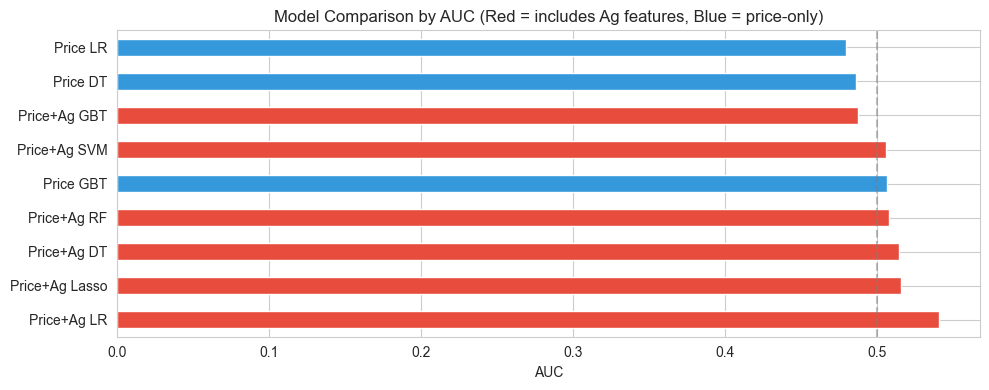

In [55]:
# ============================================================
# Side-by-side comparison (all models)
# ============================================================

all_results = {
    'Price LR': results_price,
    'Price+Ag LR': results_enhanced,
    'Price DT': results_price_dt,
    'Price+Ag DT': results_enhanced_dt,
    'Price GBT': results_price_gbt,
    'Price+Ag GBT': results_enhanced_gbt,
    'Price+Ag RF': results_enhanced_rf,
    'Price+Ag Lasso': results_enhanced_lasso,
    'Price+Ag SVM': results_enhanced_svm,
}

comparison = pd.DataFrame({
    name: [r['overall']['accuracy'], r['overall']['auc'], r['overall']['f1']]
    for name, r in all_results.items()
}, index=['Accuracy', 'AUC', 'F1']).T

comparison = comparison.sort_values('AUC', ascending=False)

print("\n" + "="*70)
print("OVERALL COMPARISON — ALL MODELS (sorted by AUC)")
print("="*70)
print(comparison.to_string(float_format='%.4f'))

# Quick bar chart
fig, ax = plt.subplots(figsize=(10, 4))
comparison['AUC'].plot.barh(ax=ax, color=['#e74c3c' if 'Ag' in n else '#3498db' for n in comparison.index])
ax.axvline(x=0.5, color='grey', linestyle='--', alpha=0.5)
ax.set_xlabel('AUC')
ax.set_title('Model Comparison by AUC (Red = includes Ag features, Blue = price-only)')
plt.tight_layout()
plt.show()


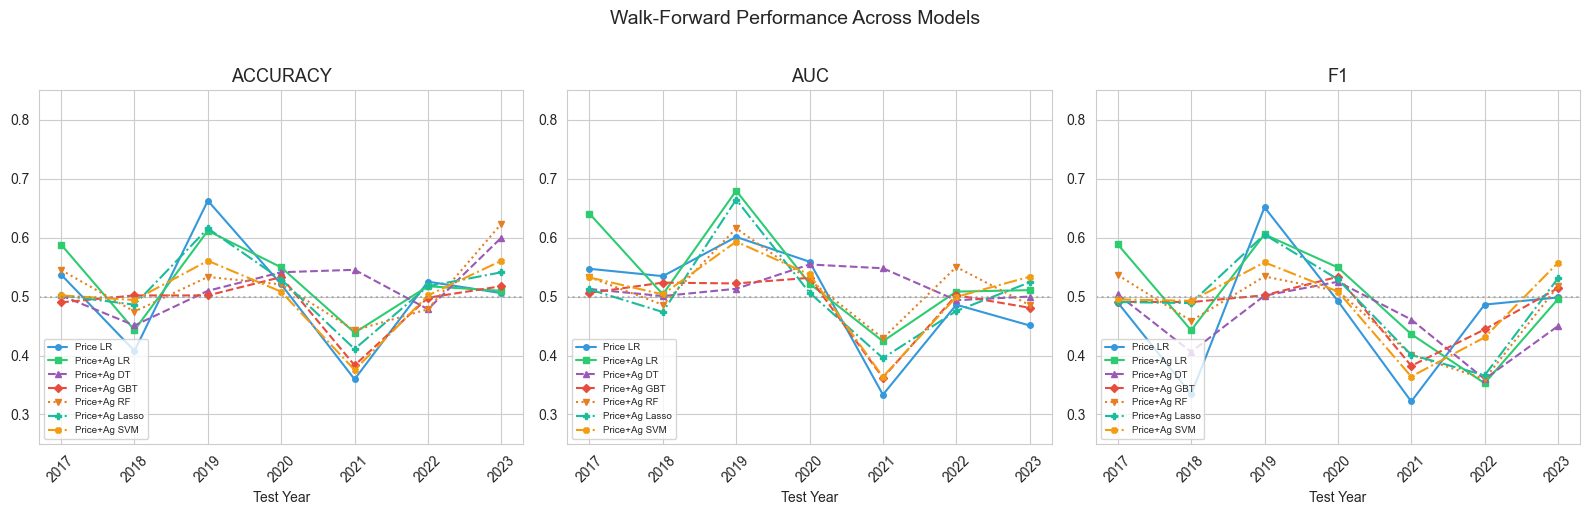

In [56]:
# ============================================================
# Yearly AUC comparison plot (selected models)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_models = {
    'Price LR':      {'marker': 'o', 'ls': '-',  'color': '#3498db'},
    'Price+Ag LR':   {'marker': 's', 'ls': '-',  'color': '#2ecc71'},
    'Price+Ag DT':   {'marker': '^', 'ls': '--', 'color': '#9b59b6'},
    'Price+Ag GBT':  {'marker': 'D', 'ls': '--', 'color': '#e74c3c'},
    'Price+Ag RF':    {'marker': 'v', 'ls': ':',  'color': '#e67e22'},
    'Price+Ag Lasso': {'marker': 'P', 'ls': '-.',  'color': '#1abc9c'},
    'Price+Ag SVM':   {'marker': 'X', 'ls': '-.',  'color': '#f39c12'},
}

for idx, metric in enumerate(['accuracy', 'auc', 'f1']):
    ax = axes[idx]
    for name, st in plot_models.items():
        m = all_results[name]['metrics_yearly']
        ax.plot(m['year'], m[metric], marker=st['marker'], ls=st['ls'],
                color=st['color'], label=name, linewidth=1.5, markersize=4)
    ax.axhline(y=0.5, color='grey', linestyle=':', alpha=0.5)
    ax.set_title(metric.upper(), fontsize=13)
    ax.set_xlabel('Test Year')
    ax.legend(fontsize=7, loc='lower left')
    ax.set_ylim(0.25, 0.85)
    ax.tick_params(axis='x', rotation=45)

fig.suptitle('Walk-Forward Performance Across Models', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


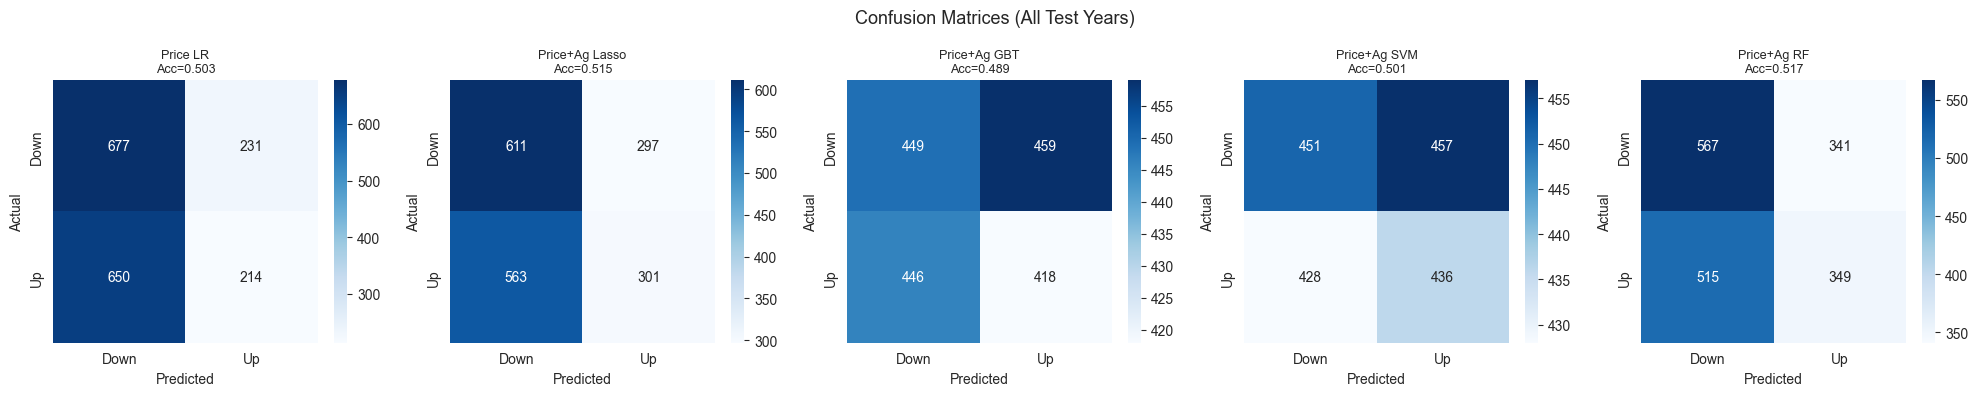

In [57]:
# ============================================================
# Confusion matrices (key models)
# ============================================================

show_models = ['Price LR', 'Price+Ag Lasso', 'Price+Ag GBT', 'Price+Ag SVM', 'Price+Ag RF']
fig, axes = plt.subplots(1, len(show_models), figsize=(4*len(show_models), 4))

for ax, name in zip(axes, show_models):
    preds = all_results[name]['predictions']
    cm = confusion_matrix(preds['Target'], preds['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    acc = accuracy_score(preds['Target'], preds['y_pred'])
    ax.set_title(f'{name}\nAcc={acc:.3f}', fontsize=9)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices (All Test Years)', fontsize=13)
plt.tight_layout()
plt.show()


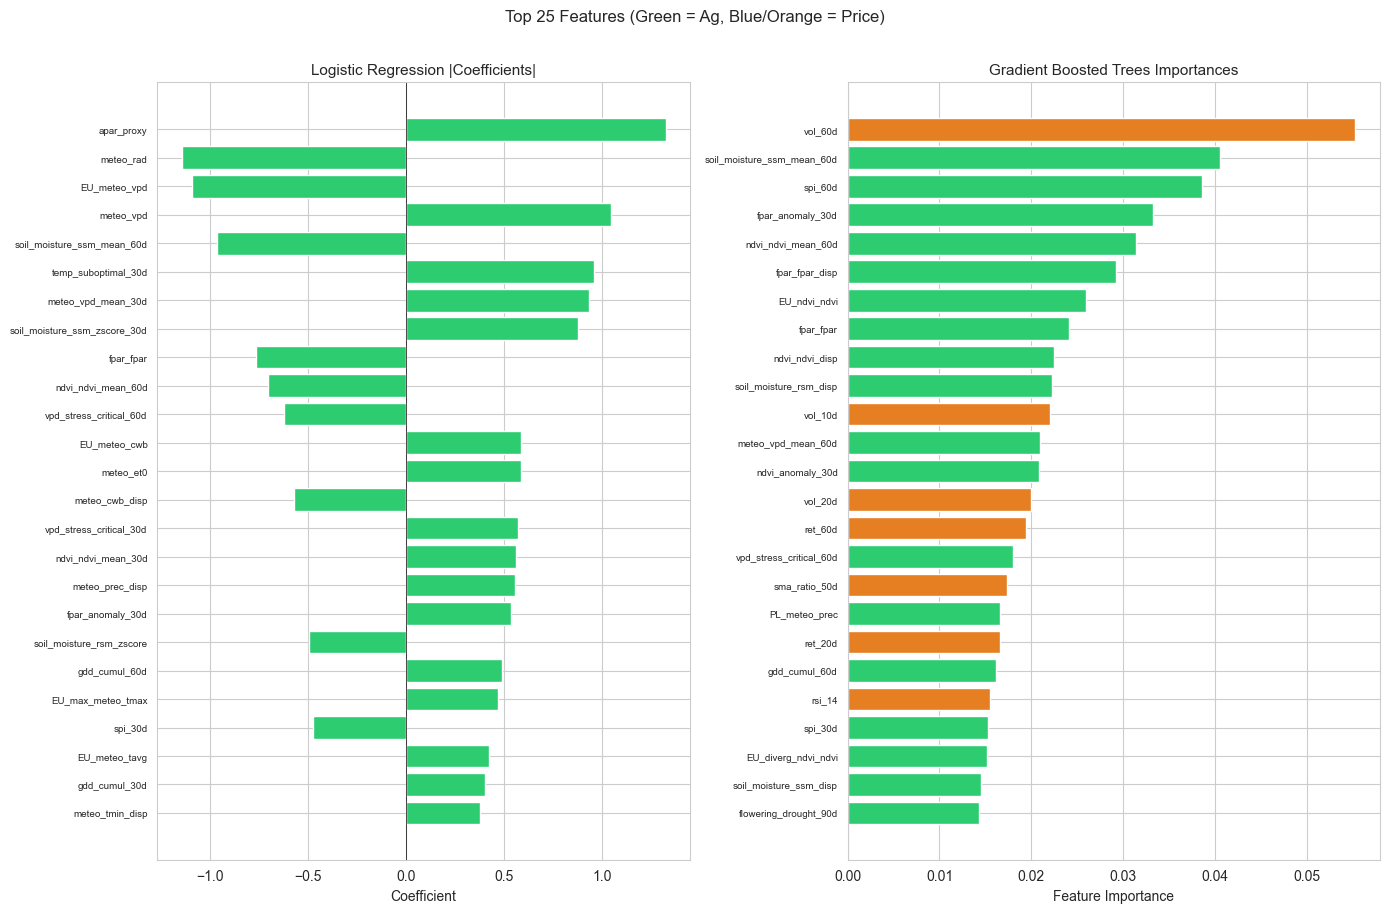


Top 15 features by GBT importance:
                   feature         type  gbt_importance
                   vol_60d        Price          0.0552
soil_moisture_ssm_mean_60d Agricultural          0.0406
                   spi_60d Agricultural          0.0386
          fpar_anomaly_30d Agricultural          0.0332
        ndvi_ndvi_mean_60d Agricultural          0.0313
            fpar_fpar_disp Agricultural          0.0292
              EU_ndvi_ndvi Agricultural          0.0260
                 fpar_fpar Agricultural          0.0241
            ndvi_ndvi_disp Agricultural          0.0225
    soil_moisture_rsm_disp Agricultural          0.0223
                   vol_10d        Price          0.0220
        meteo_vpd_mean_60d Agricultural          0.0210
          ndvi_anomaly_30d Agricultural          0.0209
                   vol_20d        Price          0.0200
                   ret_60d        Price          0.0194


In [58]:
# ============================================================
# Feature importance: LR coefficients vs GBT importances
# ============================================================

final_df = model_df_enhanced.copy()
final_df['year'] = final_df['Date'].dt.year
train_final = final_df[final_df['year'] <= 2021]

scaler_final = StandardScaler()
X_train_f = scaler_final.fit_transform(train_final[all_feature_cols])
y_train_f = train_final['Target'].values

lr_final = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs')
lr_final.fit(X_train_f, y_train_f)

gbt_final = GradientBoostingClassifier(**GBT_PARAMS)
gbt_final.fit(X_train_f, y_train_f)

importance_df = pd.DataFrame({
    'feature': all_feature_cols,
    'lr_coef': lr_final.coef_[0],
    'lr_abs': np.abs(lr_final.coef_[0]),
    'gbt_importance': gbt_final.feature_importances_
})
importance_df['type'] = importance_df['feature'].apply(
    lambda x: 'Agricultural' if x not in price_feature_cols else 'Price'
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
top_n = 25

top_lr = importance_df.nlargest(top_n, 'lr_abs')
colors_lr = ['#2ecc71' if t == 'Agricultural' else '#3498db' for t in top_lr['type']]
ax1.barh(range(top_n), top_lr['lr_coef'].values, color=colors_lr)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_lr['feature'].values, fontsize=7)
ax1.invert_yaxis()
ax1.set_xlabel('Coefficient')
ax1.set_title('Logistic Regression |Coefficients|', fontsize=11)
ax1.axvline(x=0, color='black', linewidth=0.5)

top_gbt = importance_df.nlargest(top_n, 'gbt_importance')
colors_gbt = ['#2ecc71' if t == 'Agricultural' else '#e67e22' for t in top_gbt['type']]
ax2.barh(range(top_n), top_gbt['gbt_importance'].values, color=colors_gbt)
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(top_gbt['feature'].values, fontsize=7)
ax2.invert_yaxis()
ax2.set_xlabel('Feature Importance')
ax2.set_title('Gradient Boosted Trees Importances', fontsize=11)

fig.suptitle(f'Top {top_n} Features (Green = Ag, Blue/Orange = Price)', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

print("\nTop 15 features by GBT importance:")
print(importance_df.nlargest(15, 'gbt_importance')[['feature', 'type', 'gbt_importance']]
      .to_string(index=False, float_format='%.4f'))


---
## 8. Conclusion & Feasibility Assessment

In [60]:
# ============================================================
# Summary
# ============================================================

print("="*70)
print("FINAL ASSESSMENT")
print("="*70)
print()

for name, res in all_results.items():
    o = res['overall']
    print(f"  {name:20s}  Acc={o['accuracy']:.3f}  AUC={o['auc']:.3f}  F1={o['f1']:.3f}")

# Key comparisons
best_price = max(r['overall']['auc'] for n, r in all_results.items() if 'Ag' not in n)
best_ag = max(r['overall']['auc'] for n, r in all_results.items() if 'Ag' in n)
best_name = max(all_results, key=lambda n: all_results[n]['overall']['auc'])
best_auc = all_results[best_name]['overall']['auc']

print(f"\nBest price-only AUC:    {best_price:.4f}")
print(f"Best price+ag AUC:      {best_ag:.4f}")
print(f"Ag feature lift:        {best_ag - best_price:+.4f}")
print(f"Best model overall:     {best_name} (AUC = {best_auc:.4f})")
print()


FINAL ASSESSMENT

  Price LR              Acc=0.503  AUC=0.479  F1=0.470
  Price+Ag LR           Acc=0.523  AUC=0.541  F1=0.513
  Price DT              Acc=0.490  AUC=0.487  F1=0.484
  Price+Ag DT           Acc=0.518  AUC=0.515  F1=0.516
  Price GBT             Acc=0.505  AUC=0.507  F1=0.504
  Price+Ag GBT          Acc=0.489  AUC=0.488  F1=0.489
  Price+Ag RF           Acc=0.517  AUC=0.508  F1=0.511
  Price+Ag Lasso        Acc=0.515  AUC=0.516  F1=0.502
  Price+Ag SVM          Acc=0.501  AUC=0.506  F1=0.501

Best price-only AUC:    0.5067
Best price+ag AUC:      0.5409
Ag feature lift:        +0.0343
Best model overall:     Price+Ag LR (AUC = 0.5409)

